# Uncertainty quantification using "DRIVE: Digital Retinal Images for Vessel Extraction"
 
__author__: Yongchan Kwon

This notebook is the implementation example for paper "Uncertainty quantification using Bayesian neural networks in classification: Application to biomedical segmentation", the special issue of Medical Image Analysis.

The followings are based on the Walter de Back's amazing notebook https://gitlab.com/wdeback/dl-keras-tutorial/blob/master/notebooks/3-cnn-segment-retina-uncertainty.ipynb

**Reference**

- J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "Ridge based vessel segmentation in color images of the retina", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
np.random.seed(20180621)

from skimage.external import tifffile # read tiff images
from skimage.io import imread # read gif images
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import seaborn as sns

from model import *
import utils
import time

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
print('Backend: ', K.backend())
print('Image_data_format: ', K.image_data_format())
N_train = 2000

Backend:  tensorflow
Image_data_format:  channels_last


In [3]:
# load training images
fns = sorted(glob.glob('./input/training/images/*.tif'))
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('./input/test/images/*.tif'))
x_test = np.array([tifffile.imread(fn) for fn in fns])
print('shape of raw train data: ', x_train.shape)
print('shape of raw test data: ',x_test.shape)

/usr/local/lib/python3.5/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


shape of raw train data:  (20, 584, 565, 3)
shape of raw test data:  (20, 584, 565, 3)


In [4]:
 # load training annotations
fns = sorted(glob.glob('./input/training/1st_manual/*.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
y_train = np.expand_dims(y_train, -1) # add channels dimension

# load test annotations
fns = sorted(glob.glob('./input/test/1st_manual/*.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
y_test = np.expand_dims(y_test, -1) # add channels dimension
print('train shape:', y_train.shape)
print('test shape:', y_test.shape)

train shape: (20, 584, 565, 1)
test shape: (20, 584, 565, 1)


## Preprecossing

In [5]:
x_train = utils.preprocess(x_train)
x_test = utils.preprocess(x_test)

y_train = utils.preprocess(y_train)
y_test = utils.preprocess(y_test)

min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32


In [6]:
X_train, Y_train = utils.get_random_snippets(x_train, y_train, number=N_train, size=(96,96))
X_test, Y_test = utils.get_random_snippets(x_test, y_test, number=1000, size=(96,96))

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (2000, 96, 96, 3)
Y_train shape:  (2000, 96, 96, 1)
X_test shape:  (1000, 96, 96, 3)
Y_test shape:  (1000, 96, 96, 1)


<Figure size 1440x1440 with 0 Axes>

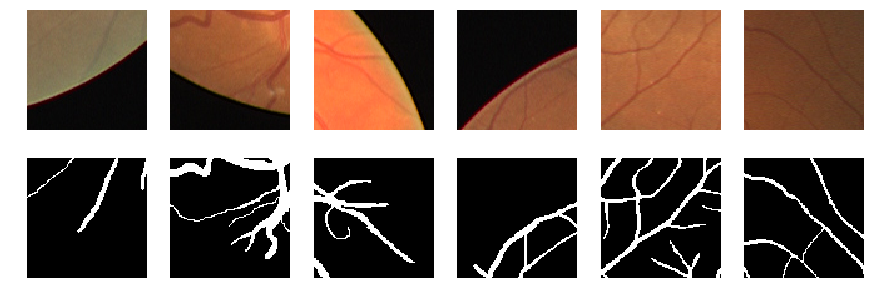

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]
M=6
list_index = np.random.randint(low=0, high=X_train.shape[0], size=M)
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(2,M)
for k, ind in enumerate(list_index):
    ax[0,k].imshow(X_train[ind])
    ax[1,k].imshow(Y_train[ind,:,:,0], cmap='gray')
    
    ax[0,k].axis('off')
    ax[1,k].axis('off')

fig.savefig('./fig/DRIVE_example_2000')

In [8]:
model = UNet(N_filters=16)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', dice_coefficient, precision_smooth, recall_smooth])
print("Number of parameters: ", model.count_params())

Number of parameters:  1115265


In [9]:
batch_size = 32
epochs = 200
info_check_string='./weights/DRIVE_stochastic_sample_2000.hdf5'
early_stopping=EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint=ModelCheckpoint(info_check_string, monitor='loss', save_best_only=True)

In [10]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=1,
                      validation_split=0.2, # 4 samples are used for a validation set
                      callbacks=[early_stopping, model_checkpoint]) 

Train on 1600 samples, validate on 400 samples
Epoch 1/200
1600/1600 [==============================] - 9s 6ms/step - loss: 0.7295 - binary_accuracy: 0.5715 - dice_coefficient: 0.2057 - precision_smooth: 0.1281 - recall_smooth: 0.5255 - val_loss: 0.7339 - val_binary_accuracy: 0.6052 - val_dice_coefficient: 0.2155 - val_precision_smooth: 0.1346 - val_recall_smooth: 0.5431
Epoch 2/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.4991 - binary_accuracy: 0.7938 - dice_coefficient: 0.3222 - precision_smooth: 0.2106 - recall_smooth: 0.6973 - val_loss: 0.3958 - val_binary_accuracy: 0.8671 - val_dice_coefficient: 0.3791 - val_precision_smooth: 0.2686 - val_recall_smooth: 0.6463
Epoch 3/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.3251 - binary_accuracy: 0.9244 - dice_coefficient: 0.4196 - precision_smooth: 0.2997 - recall_smooth: 0.7098 - val_loss: 0.2454 - val_binary_accuracy: 0.9226 - val_dice_coefficient: 0.4068 - val_precision_smooth: 0.3835 

Epoch 26/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1186 - binary_accuracy: 0.9551 - dice_coefficient: 0.7091 - precision_smooth: 0.6990 - recall_smooth: 0.7220 - val_loss: 0.1280 - val_binary_accuracy: 0.9524 - val_dice_coefficient: 0.6999 - val_precision_smooth: 0.6866 - val_recall_smooth: 0.7139
Epoch 27/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1177 - binary_accuracy: 0.9553 - dice_coefficient: 0.7102 - precision_smooth: 0.6998 - recall_smooth: 0.7229 - val_loss: 0.1254 - val_binary_accuracy: 0.9530 - val_dice_coefficient: 0.6966 - val_precision_smooth: 0.6869 - val_recall_smooth: 0.7069
Epoch 28/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1164 - binary_accuracy: 0.9557 - dice_coefficient: 0.7131 - precision_smooth: 0.7026 - recall_smooth: 0.7260 - val_loss: 0.1288 - val_binary_accuracy: 0.9525 - val_dice_coefficient: 0.6959 - val_precision_smooth: 0.7142 - val_recall_smooth: 0.6787
Epoch 29/200
160

Epoch 51/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1012 - binary_accuracy: 0.9598 - dice_coefficient: 0.7433 - precision_smooth: 0.7397 - recall_smooth: 0.7495 - val_loss: 0.1240 - val_binary_accuracy: 0.9545 - val_dice_coefficient: 0.7180 - val_precision_smooth: 0.7206 - val_recall_smooth: 0.7156
Epoch 52/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1000 - binary_accuracy: 0.9603 - dice_coefficient: 0.7467 - precision_smooth: 0.7439 - recall_smooth: 0.7512 - val_loss: 0.1280 - val_binary_accuracy: 0.9533 - val_dice_coefficient: 0.7093 - val_precision_smooth: 0.7026 - val_recall_smooth: 0.7163
Epoch 53/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0995 - binary_accuracy: 0.9603 - dice_coefficient: 0.7465 - precision_smooth: 0.7425 - recall_smooth: 0.7524 - val_loss: 0.1250 - val_binary_accuracy: 0.9549 - val_dice_coefficient: 0.7255 - val_precision_smooth: 0.7410 - val_recall_smooth: 0.7108
Epoch 54/200
160

In [11]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss, acc, dice, precision, recall):', score)

1000/1000 [==============================] - 1s 1ms/step
Test loss, acc, dice, precision, recall): [0.12630774545669557, 0.955008460521698, 0.7202619128227233, 0.7406656622886658, 0.7016640419960022]


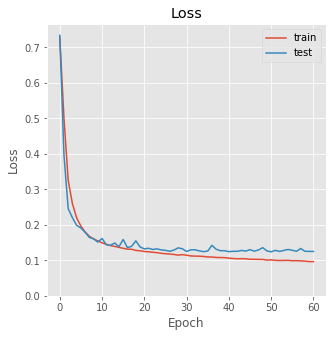

In [12]:
 def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    if validation:
        ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'test'])
    
    plt.savefig('./fig/loss_curve_2000')
    
plot_history(history, validation=True)

# Bayesian neural network: stochastic feed forward

In [13]:
num = len(X_test)
list_stochastic_feed_forwards = [3,5,10,15,20,30]
results = np.zeros((5, len(list_stochastic_feed_forwards)))
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    start = time.time()
    alea_mean = 0.
    epis_mean = 0.
    dice_mean = 0.
    for i in range(num):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=num_stochastic_T)
        alea_mean += np.mean(aleatoric) / num
        epis_mean += np.mean(epistemic) / num
        dice_mean += scores[0] / num
    
    end = time.time()
    print('T: ', num_stochastic_T)
    print('Exec time per prediction = {:.3f}'.format((end-start)/num))
    print('aleatoric: ', alea_mean)
    print('epistemic: ', epis_mean)    
    print('Dice: ', dice_mean)    
    
    results[0,ind]=num_stochastic_T
    results[1,ind]=(end-start)/num
    results[2,ind]=alea_mean
    results[3,ind]=epis_mean  
    results[4,ind]=dice_mean

print('-'*30)
print(results)    
print('-'*30)


T:  3
Exec time per prediction = 0.043
aleatoric:  0.027224977119243716
epistemic:  0.001616667818328098
Dice:  0.9548942053318007
T:  5
Exec time per prediction = 0.063
aleatoric:  0.027236774078686698
epistemic:  0.0019315296700806357
Dice:  0.9552116975784294
T:  10
Exec time per prediction = 0.113
aleatoric:  0.027251575225905978
epistemic:  0.0021674169226407673
Dice:  0.954978299081325
T:  15
Exec time per prediction = 0.164
aleatoric:  0.027247499355697098
epistemic:  0.0022495759817511467
Dice:  0.9549389110207558
T:  20
Exec time per prediction = 0.215
aleatoric:  0.027237761982367364
epistemic:  0.002286041925757673
Dice:  0.9548461374640468
T:  30
Exec time per prediction = 0.315
aleatoric:  0.02724751255707813
epistemic:  0.0023270566612418435
Dice:  0.9549019103050223
------------------------------
[[3.00000000e+00 5.00000000e+00 1.00000000e+01 1.50000000e+01
  2.00000000e+01 3.00000000e+01]
 [4.34375765e-02 6.26383622e-02 1.12853648e-01 1.64133944e-01
  2.14760788e-01 3.1

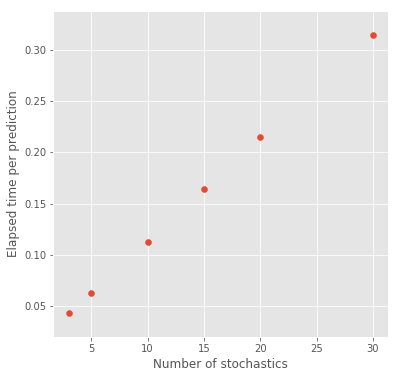

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex=True)
# plot history for loss
ax.scatter(results[0],results[1])
ax.set_ylabel('Elapsed time per prediction')
ax.set_xlabel('Number of stochastics')
plt.savefig('./fig/elapsed_time_vs_feed_2000')

In [15]:
# Case T = 5
num = len(X_test)
start = time.time()
list_alea = []
list_epis = []
for i in range(num):
    image = X_test[i]
    gt    = Y_test[i]
    prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=5)
    list_alea.append(aleatoric.reshape(-1))
    list_epis.append(epistemic.reshape(-1))

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))
print('aleatoric: ', alea_mean)
print('epistemic: ', epis_mean)    
print('Dice: ', scores[0])    


Exec time per prediction = 0.062
aleatoric:  0.02724751255707813
epistemic:  0.0023270566612418435
Dice:  0.9699435830116272


In [16]:
list_alea = np.hstack(list_alea)
list_epis = np.hstack(list_epis)

print('aleatoric mean: ', np.mean(list_alea))
print('epistemic mean: ', np.mean(list_epis))

aleatoric mean:  0.027231874
epistemic mean:  0.0019218976


# Epistemic vs Aleatoric

In [17]:
threshold = np.percentile(list_alea, 99)
alea_index = (list_alea > threshold)

In [26]:
data[:5], list_epis[alea_index][:5]

(array([[0.0118183 , 0.23600805],
        [0.01332231, 0.2350181 ],
        [0.01259473, 0.2342771 ],
        [0.01108353, 0.23728935],
        [0.01291105, 0.23428988]], dtype=float32),
 array([0.0118183 , 0.01332231, 0.01259473, 0.01108353, 0.01291105],
       dtype=float32))

/usr/local/lib/python3.5/dist-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


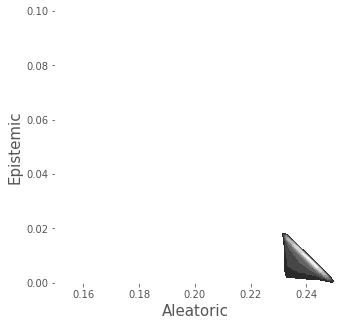

In [29]:
plt.figure(figsize=(5,5))
data = np.vstack([list_alea[alea_index], list_epis[alea_index]]).T
ax = sns.kdeplot(data, shade = True, cmap = "gray", cbar=False)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel('Aleatoric', fontsize = 15)
ax.set_ylabel('Epistemic', fontsize = 15)
ax.set_xlim(0.15, 0.25)
ax.set_ylim(0, 0.1)
plt.savefig('./fig/epis_vs_alea_2000')

# Conditional expectation of epistemic

In [19]:
threshold_99 = np.percentile(list_alea, 99.)
threshold_995 = np.percentile(list_alea, 99.5)
threshold_999 = np.percentile(list_alea, 99.9)
threshold_9995 = np.percentile(list_alea, 99.95)
print(threshold_99, threshold_995, threshold_999, threshold_9995)
# alea_index = (list_alea > threshold)

0.23216851070523262 0.23825240150094035 0.24482269594073297 0.24626031546294747


In [20]:
print('conditional expectation of epistemic')
print(
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.05) and (list_alea[i] < 0.1)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.1) and (list_alea[i] < 0.15)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.15) and (list_alea[i] < 0.2)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.2) and (list_alea[i] < 0.25)])
    )

conditional expectation of epistemic
0.005635127 0.011849124 0.017931616 0.014276734


In [21]:
96*96*2000/(10 ** 6)

18.432